## 1. Impor Pustaka


In [1]:
# data
import pandas as pd
import numpy as np

# visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# pemprosesan & pemodelan data
import sklearn
import skops.io as sio
from skops.io import dump, load, get_untrusted_types
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import minmax_scale, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# monitoring model
import mlflow
import mlflow.sklearn

## 2. Baca Kumpulan Data

In [2]:
data = pd.read_csv(f"Data/credit_risk_dataset.csv")

data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,35,70452,MORTGAGE,1.0,EDUCATION,C,8420,11.20,0,0.09,N,9
1,23,73884,MORTGAGE,9.0,EDUCATION,C,8977,8.47,0,0.12,N,6
2,31,153332,MORTGAGE,32.0,EDUCATION,A,8779,6.14,0,0.04,N,4
3,28,15699,MORTGAGE,7.0,EDUCATION,B,2262,NaN,1,0.15,N,4
4,24,28689,MORTGAGE,2.0,EDUCATION,C,7569,10.05,0,0.20,Y,7


In [3]:
data.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
495,25,64469,MORTGAGE,0.0,PERSONAL,C,18847,10.08,0,0.31,N,4
496,30,26499,MORTGAGE,0.0,VENTURE,C,10947,7.89,0,0.32,N,7
497,25,139170,RENT,16.0,EDUCATION,A,19818,11.43,0,0.16,N,5
498,37,62624,RENT,0.0,HOMEIMPROVEMENT,D,19208,18.31,1,0.31,N,5
499,30,50213,RENT,26.0,VENTURE,A,5601,7.24,0,0.15,N,11


In [4]:
data.shape

(500, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  500 non-null    int64  
 1   person_income               500 non-null    int64  
 2   person_home_ownership       500 non-null    object 
 3   person_emp_length           489 non-null    float64
 4   loan_intent                 500 non-null    object 
 5   loan_grade                  500 non-null    object 
 6   loan_amnt                   500 non-null    int64  
 7   loan_int_rate               459 non-null    float64
 8   loan_status                 500 non-null    int64  
 9   loan_percent_income         500 non-null    float64
 10  cb_person_default_on_file   500 non-null    object 
 11  cb_person_cred_hist_length  500 non-null    int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 47.0+ KB


## 3. Analisis Data Eksplorasi


In [6]:
data.isnull().sum()

person_age                     0
person_income                  0
person_home_ownership          0
person_emp_length             11
loan_intent                    0
loan_grade                     0
loan_amnt                      0
loan_int_rate                 41
loan_status                    0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
dtype: int64

In [7]:
data.nunique()

person_age                     27
person_income                 498
person_home_ownership           4
person_emp_length              33
loan_intent                     6
loan_grade                      6
loan_amnt                     493
loan_int_rate                 382
loan_status                     2
loan_percent_income            50
cb_person_default_on_file       2
cb_person_cred_hist_length     16
dtype: int64

In [8]:
data.loan_status.value_counts()

loan_status
0    386
1    114
Name: count, dtype: int64

In [9]:
data.duplicated().sum()

np.int64(0)

In [10]:
# data.corr()
data.select_dtypes(include=np.number).corr()
# data.select_dtypes().corr()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.133432,0.079178,0.068988,0.031961,0.033547,-0.012646,0.622463
person_income,0.133432,1.000000,0.105083,0.291326,0.039229,-0.164569,-0.409463,0.031506
person_emp_length,0.079178,0.105083,1.000000,0.021447,-0.118481,-0.067345,-0.041331,0.011227
loan_amnt,0.068988,0.291326,0.021447,1.000000,0.143880,0.104416,0.668034,0.112626
loan_int_rate,0.031961,0.039229,-0.118481,0.143880,1.000000,0.132580,0.102636,-0.076196
loan_status,0.033547,-0.164569,-0.067345,0.104416,0.132580,1.000000,0.271638,-0.017598
loan_percent_income,-0.012646,-0.409463,-0.041331,0.668034,0.102636,0.271638,1.000000,0.073597
cb_person_cred_hist_length,0.622463,0.031506,0.011227,0.112626,-0.076196,-0.017598,0.073597,1.000000


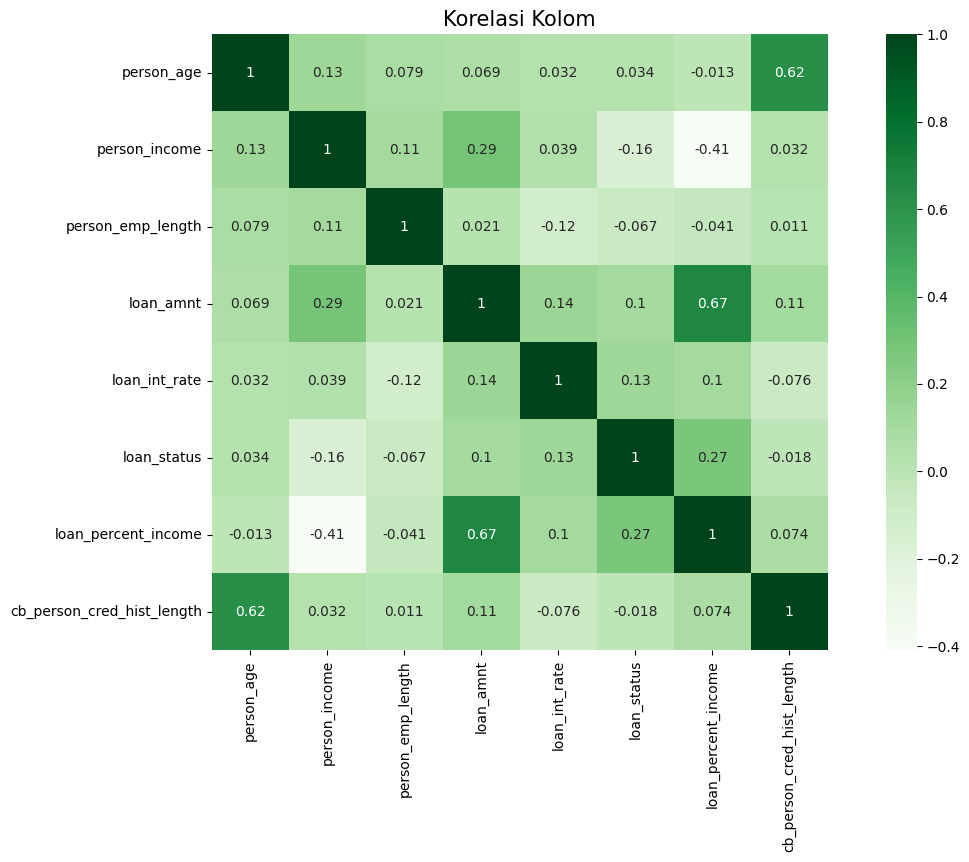

In [11]:
# perikas korelasi antar kolom
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(data.select_dtypes(include=np.number).corr(), vmax =1., square = True, annot = True,cmap='Greens' )
plt.title('Korelasi Kolom',fontsize=15);

<div style="background-color: #ddefdd; padding: 10px; border-radius: 10px; color: #007d3c; text-align: center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="font-size: 24px;">Deskripsi Fitur</h1>
</div>

<div style="background-color: #f3faf3; padding: 15px; border-radius: 10px; margin-top: 20px; text-align: left;">
    <ul>
        <li><b>person_age:</b> Usia individu yang mengajukan pinjaman.</li>
        <li><b>person_income:</b> Penghasilan tahunan individu.</li>
        <li><b>person_home_ownership:</b> Jenis kepemilikan rumah individu.
            <ul>
                <li>rent: Individu tersebut saat ini menyewa properti.</li>
                <li>mortgage: Individu tersebut memiliki hipotek (perjanjian pinjaman) atas properti yang mereka miliki.</li>
                <li>own: Individu tersebut memiliki rumah mereka secara langsung.</li>
                <li>other: Kategori kepemilikan rumah lain yang mungkin spesifik untuk kumpulan data.</li>
            </ul>
        </li>
        <li><b>person_emp_length:</b> Lama kerja individu dalam tahun.</li>
        <li><b>loan_intent:</b> Maksud di balik pengajuan pinjaman.
          <ul>
            <li>Education: Peminjam perlu membiayai peindidikan</li>
            <li>Medical: Peminjam perlu membiayai pengobatan</li>
            <li>Venture: Peminjam perlu dana untuk pengembangan bisnis</li>
            <li>Personal: Peminjam perlu membiayai biaya hidup</li>
            <li>Debtconsolidation: Peminjam ingin menggabungkan beberapa pinjaman sebelumnya menjadi satu pinjaman</li>
            <li>Homeimprovement: Peminjam perlu melakukan perbaikan rumah</li>
          </ul>
        </li>
        <li><b>loan_grade:</b> Nilai yang diberikan untuk pinjaman berdasarkan kelayakan kredit peminjam.
            <ul>
                <li>A: Peminjam memiliki kelayakan kredit yang tinggi, menunjukkan risiko rendah.</li>
                <li>B: Peminjam relatif berisiko rendah, tetapi tidak layak dikreditkan seperti Grade A.</li>
                <li>C: Kelayakan kredit peminjam sedang.</li>
                <li>D: Peminjam dianggap memiliki risiko lebih tinggi dibandingkan dengan nilai sebelumnya.</li>
                <li>E: Kelayakan kredit peminjam lebih rendah, menunjukkan risiko yang lebih tinggi.</li>
                <li>F: Peminjam menimbulkan risiko kredit yang signifikan.</li>
                <li>G: Kelayakan kredit peminjam adalah yang terendah, menandakan risiko tertinggi.</li>
            </ul>
        </li>
        <li><b>loan_amnt:</b> Jumlah pinjaman yang diminta oleh individu.</li>
        <li><b>loan_int_rate:</b> Suku bunga yang terkait dengan pinjaman.</li>
        <li><b>loan_status:</b> Status pinjaman dari pengaju pinjaman.
            <ul>
                <li>0: Non-default - Peminjam berhasil menerima pinjaman dan potensi adanya gagal bayar rendah.</li>
                <li>1: Default - Peminjam gagal menerima pinjaman dan potensi gagal bayar tinggi.</li>
            </ul>
        </li>
        <li><b>loan_percent_income:</b> Persentase pendapatan yang diwakili oleh jumlah pinjaman.</li>
        <li><b>cb_person_default_on_file:</b> Riwayat gagal bayar individu sesuai catatan biro kredit.
            <ul>
                <li>Y: Individu tersebut memiliki riwayat gagal bayar pada file kredit mereka.</li>
                <li>N: Individu tersebut tidak memiliki riwayat gagal bayar.</li>
            </ul>
        </li>
        <li><b>cb_preson_cred_hist_length:</b> Panjang riwayat kredit untuk individu.</li>
    </ul>
</div>


## 4. Membersihkan data


In [13]:
data.isnull().sum()

person_age                     0
person_income                  0
person_home_ownership          0
person_emp_length             11
loan_intent                    0
loan_grade                     0
loan_amnt                      0
loan_int_rate                 41
loan_status                    0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
dtype: int64

In [14]:
# drop values that are null
data.dropna(axis=0,inplace=True)

In [16]:
data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [18]:
data.duplicated().sum()

np.int64(0)

In [19]:
data = data.drop_duplicates()

In [20]:
data.duplicated().sum()

np.int64(0)

In [21]:
#person_age max 144 (issue)
#person_emp_length max 123 (issue)
data.reset_index(inplace = True)

In [22]:
data['person_age'].value_counts()

person_age
24    41
23    39
25    38
26    37
22    37
28    32
27    31
21    29
32    28
31    23
29    23
30    20
33    17
34    11
35    10
37     7
38     5
39     3
44     3
45     3
41     2
36     2
20     2
40     2
42     1
43     1
46     1
Name: count, dtype: int64

<BarContainer object of 27 artists>

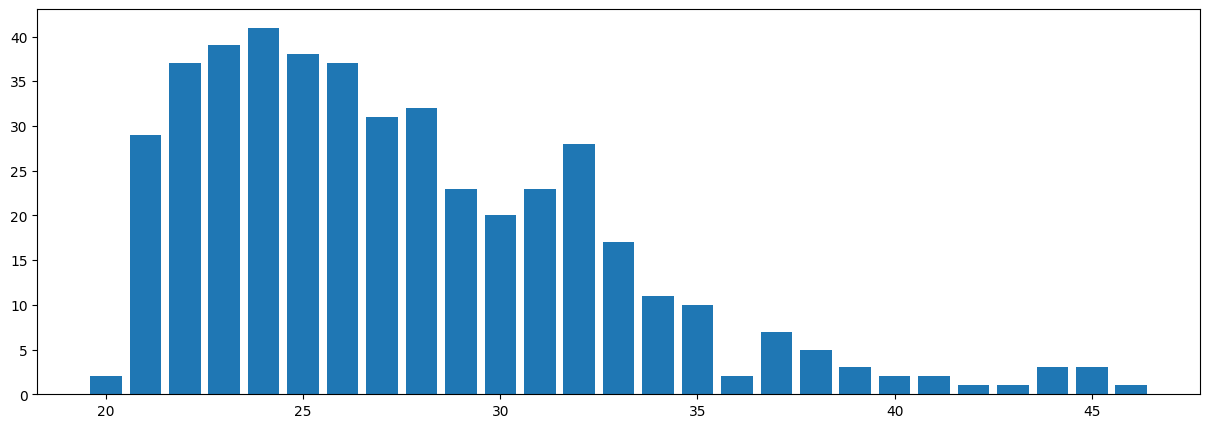

In [23]:
verti = data['person_age'].value_counts().values
hori = data['person_age'].value_counts().index
fig = plt.figure(figsize = (15, 5))
plt.bar(hori, verti)

In [25]:
(data['person_age'].value_counts().values>55).sum()

np.int64(0)

In [26]:
data = data.drop(data[data['person_age'] > 55].index, axis=0)

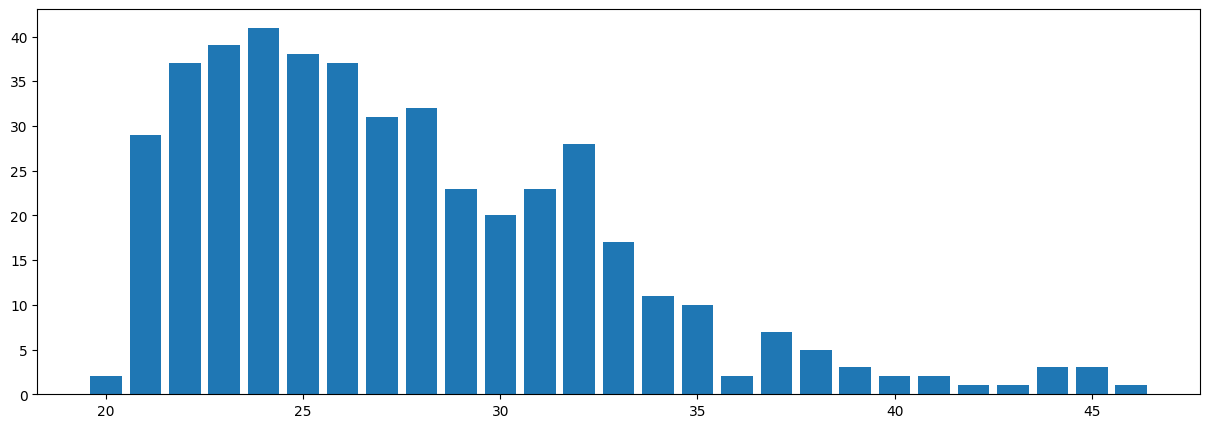

In [27]:
verti = data['person_age'].value_counts().values
hori = data['person_age'].value_counts().index
fig = plt.figure(figsize = (15, 5))
plt.bar(hori, verti)
plt.show()

In [28]:
data['person_emp_length'].value_counts().sort_index()

person_emp_length
0.0     132
1.0      70
2.0      38
3.0      21
4.0      26
5.0      26
6.0      17
7.0      11
8.0      13
9.0       6
10.0     14
11.0      8
12.0      3
13.0      5
14.0      4
15.0      8
16.0      7
17.0      1
18.0     10
19.0      3
20.0      1
22.0      2
23.0      2
24.0      3
26.0      3
29.0      1
31.0      1
32.0      4
33.0      1
34.0      3
36.0      2
48.0      1
57.0      1
Name: count, dtype: int64

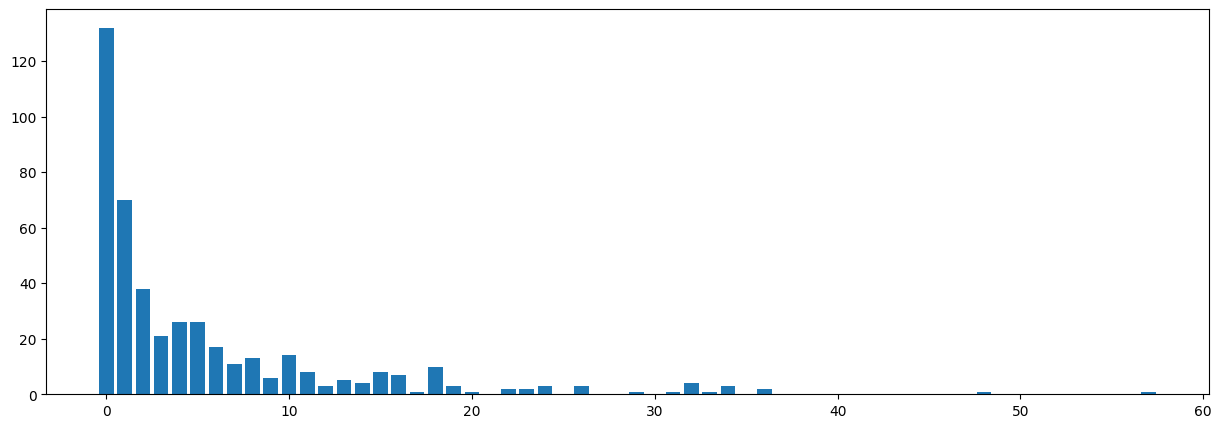

In [29]:
verti = data['person_emp_length'].value_counts().values
hori = data['person_emp_length'].value_counts().index
fig = plt.figure(figsize = (15, 5))
plt.bar(hori, verti)
plt.show()

In [30]:
data = data.drop(data[data['person_emp_length'] > 38].index, axis=0)

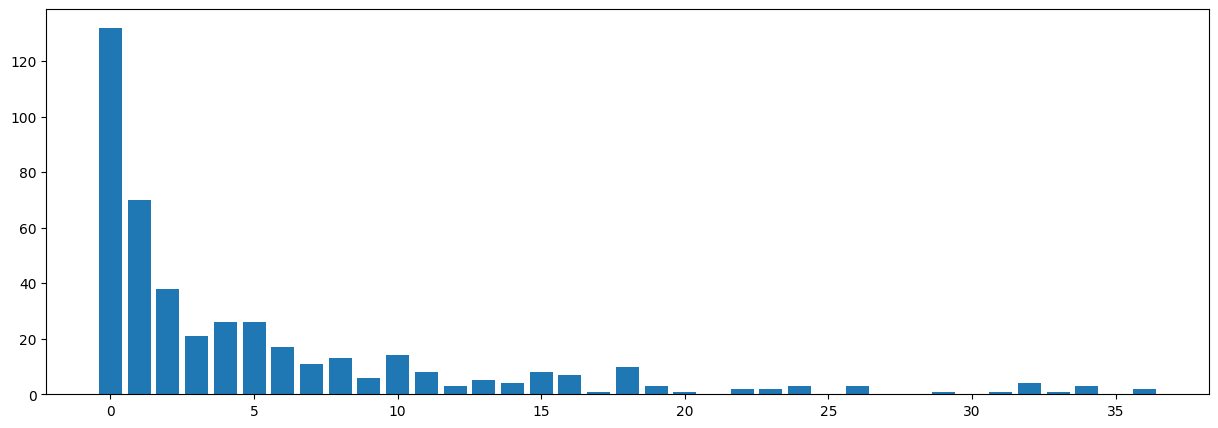

In [31]:
verti = data['person_emp_length'].value_counts().values
hori = data['person_emp_length'].value_counts().index
fig = plt.figure(figsize = (15, 5))
plt.bar(hori, verti)
plt.show()

## 5. Feature Engineering


In [32]:
data = data.drop(['index'], axis=1)
data.reset_index(inplace = True)
data = data.drop(['index'], axis=1)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  446 non-null    int64  
 1   person_income               446 non-null    int64  
 2   person_home_ownership       446 non-null    object 
 3   person_emp_length           446 non-null    float64
 4   loan_intent                 446 non-null    object 
 5   loan_grade                  446 non-null    object 
 6   loan_amnt                   446 non-null    int64  
 7   loan_int_rate               446 non-null    float64
 8   loan_status                 446 non-null    int64  
 9   loan_percent_income         446 non-null    float64
 10  cb_person_default_on_file   446 non-null    object 
 11  cb_person_cred_hist_length  446 non-null    int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 41.9+ KB


In [34]:
# Mengonversi Data Kategorikal menjadi Numerik (Label Encoding)
cat_columns = ['cb_person_default_on_file', 'person_home_ownership','loan_intent']

default_on_file = LabelEncoder()
default_on_file.fit( data[cat_columns[0]])

home = LabelEncoder()
home.fit( data[cat_columns[1]] )

loan = LabelEncoder()
loan.fit( data[cat_columns[2]] )

LabelEncoder()

In [35]:
print(default_on_file.classes_)
print(home.classes_)
print(loan.classes_)

['N' 'Y']
['MORTGAGE' 'OTHER' 'OWN' 'RENT']
['DEBTCONSOLIDATION' 'EDUCATION' 'HOMEIMPROVEMENT' 'MEDICAL' 'PERSONAL'
 'VENTURE']


In [36]:
print(default_on_file.transform(default_on_file.classes_) )
print(home.transform(home.classes_) )
print(loan.transform(loan.classes_) )

[0 1]
[0 1 2 3]
[0 1 2 3 4 5]


In [37]:
default_on_file.transform(['N'])[0]

np.int64(0)

In [38]:
data[cat_columns[0] ].apply( lambda x: default_on_file.transform([x])[0] )

0      0
1      0
2      0
3      1
4      0
      ..
441    0
442    0
443    0
444    0
445    0
Name: cb_person_default_on_file, Length: 446, dtype: int64

In [39]:
# Konversi data kategorikal menjadi data numerik
data[cat_columns[0] ] = data[cat_columns[0] ].apply( lambda x: default_on_file.transform([x])[0] )
data[cat_columns[1] ] = data[cat_columns[1] ].apply( lambda x: home.transform([x])[0] )
data[cat_columns[2] ] = data[cat_columns[2] ].apply( lambda x: loan.transform([x])[0] )

In [40]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,35,70452,0,1.0,1,C,8420,11.20,0,0.09,0,9
1,23,73884,0,9.0,1,C,8977,8.47,0,0.12,0,6
2,31,153332,0,32.0,1,A,8779,6.14,0,0.04,0,4
3,24,28689,0,2.0,1,C,7569,10.05,0,0.20,1,7
4,32,48881,2,8.0,0,A,21342,9.73,0,0.43,0,13


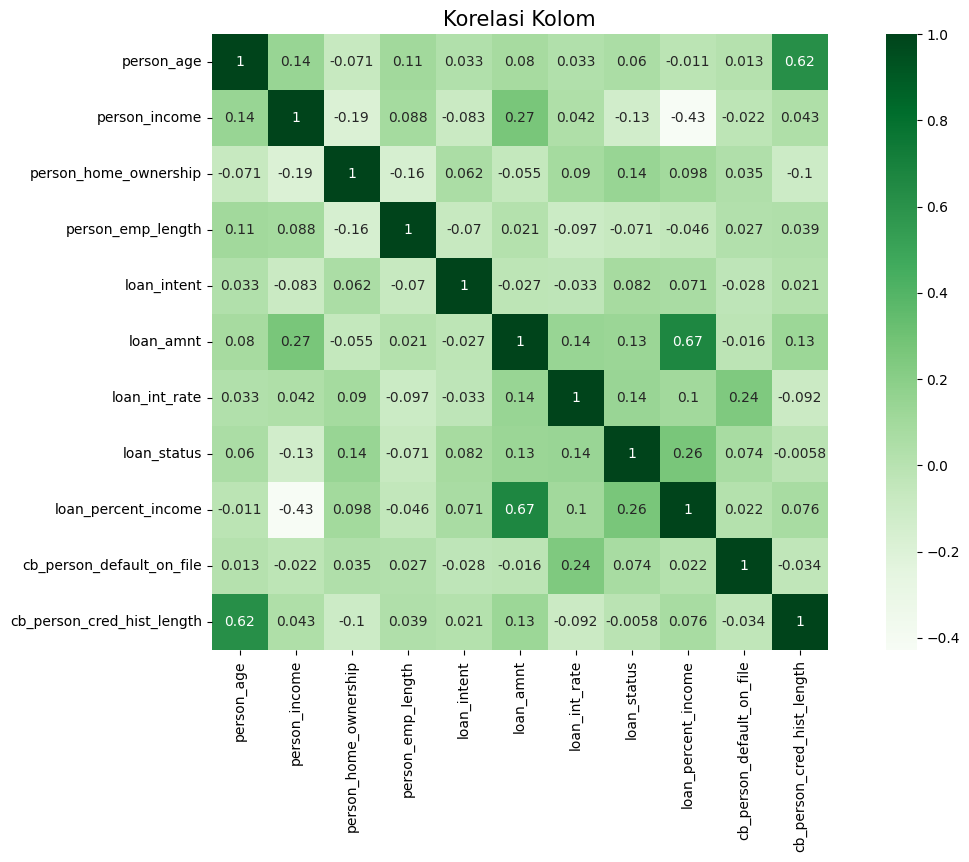

In [41]:
# periksa korelasi antar kolom
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(data.select_dtypes(include=np.number).corr(), vmax =1., square = True, annot = True,cmap='Greens' )
plt.title('Korelasi Kolom',fontsize=15);

## 6. Prapemrosesan Data

Preproses data: sesuaikan porsi data berdasarkan loan_status

In [42]:
data['loan_status'].value_counts()

loan_status
0    347
1     99
Name: count, dtype: int64

In [43]:
cleaned_data = data.copy()

In [44]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  446 non-null    int64  
 1   person_income               446 non-null    int64  
 2   person_home_ownership       446 non-null    int64  
 3   person_emp_length           446 non-null    float64
 4   loan_intent                 446 non-null    int64  
 5   loan_grade                  446 non-null    object 
 6   loan_amnt                   446 non-null    int64  
 7   loan_int_rate               446 non-null    float64
 8   loan_status                 446 non-null    int64  
 9   loan_percent_income         446 non-null    float64
 10  cb_person_default_on_file   446 non-null    int64  
 11  cb_person_cred_hist_length  446 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 41.9+ KB


In [45]:
cleaned_data['loan_status'].value_counts()

loan_status
0    347
1     99
Name: count, dtype: int64

In [46]:
rus = RandomUnderSampler(random_state=42)

X, y = rus.fit_resample( cleaned_data.drop(["loan_status"], axis=1), cleaned_data["loan_status"])

In [47]:
y.value_counts()

loan_status
0    99
1    99
Name: count, dtype: int64

In [48]:
y.head()

417    0
153    0
421    0
353    0
401    0
Name: loan_status, dtype: int64

In [50]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
417,31,152726,0,0.0,5,E,5394,8.36,0.02,0,6
153,22,44351,0,10.0,0,D,10572,13.49,0.26,0,3
421,34,52229,2,0.0,0,A,8345,7.51,0.20,0,9
353,25,50699,0,4.0,2,A,3896,6.23,0.07,0,8
401,31,71935,0,2.0,2,C,9191,7.71,0.13,0,13


Proses data

In [51]:
# Mengahpus kolom 'loan grade'
X = X.drop(['loan_grade'], axis=1)

In [52]:
# Pembagian Data untuk Pelatihan dan Pengujian
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

In [53]:
print(x_train.shape,x_test.shape)

(138, 10) (60, 10)


In [54]:
x_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [55]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 138 entries, 3 to 12
Series name: loan_status
Non-Null Count  Dtype
--------------  -----
138 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [56]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 60 entries, 127 to 270
Series name: loan_status
Non-Null Count  Dtype
--------------  -----
60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [57]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 3 to 12
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  138 non-null    int64  
 1   person_income               138 non-null    int64  
 2   person_home_ownership       138 non-null    int64  
 3   person_emp_length           138 non-null    float64
 4   loan_intent                 138 non-null    int64  
 5   loan_amnt                   138 non-null    int64  
 6   loan_int_rate               138 non-null    float64
 7   loan_percent_income         138 non-null    float64
 8   cb_person_default_on_file   138 non-null    int64  
 9   cb_person_cred_hist_length  138 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 11.9 KB


In [58]:
x_train.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
38,27,47157,3,0.0,5,8401,15.12,0.20,1,7
296,25,23984,3,0.0,4,3550,7.08,0.16,0,6
30,31,91701,0,1.0,2,23188,8.20,0.36,0,9
334,43,51722,3,9.0,3,21358,13.14,0.48,0,12
12,22,36902,3,20.0,1,8119,11.93,0.25,0,3


In [59]:
y_train.tail()

38     1
296    0
30     0
334    1
12     1
Name: loan_status, dtype: int64

In [60]:
x_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
127,35,52393,0,0.0,1,1104,7.57,0.02,0,6
73,23,50665,0,0.0,5,20770,17.03,0.41,1,5
387,23,55111,0,22.0,4,17683,10.31,0.33,0,6
181,28,74948,0,18.0,0,9067,7.55,0.12,1,6
238,23,46235,0,11.0,3,28658,10.19,0.49,0,4


In [61]:
y_test.head()

127    0
73     1
387    0
181    1
238    1
Name: loan_status, dtype: int64

## 7. Pelatihan & Pengujian Sklearn

In [64]:
from sklearn.metrics import accuracy_score, f1_score

model = Pipeline(
    steps=[
        ("model", ExtraTreesClassifier())
    ]
)
model.fit(x_train, y_train)

Pipeline(steps=[('model', ExtraTreesClassifier())])

In [65]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score

# uji model
predict = model.predict(x_test)
akurasi = accuracy_score(y_test, predict)
f1 = f1_score(y_test, predict, average='macro')

print("Accuracy: {}%, F1: {}".format(round(akurasi, 2), round(f1, 2) ) )

Accuracy: 0.6%, F1: 0.6


In [59]:
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(akurasi, 2)}, F1 Score = {round(f1, 2)}.")

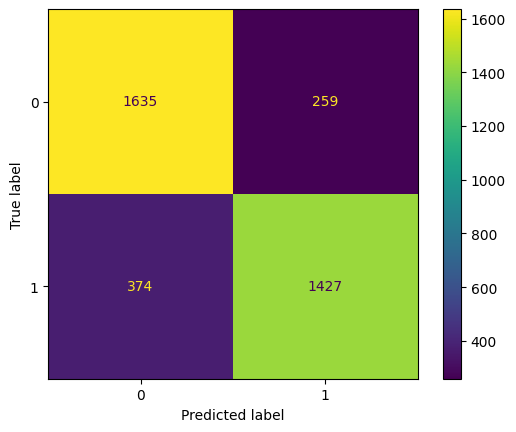

In [ ]:
cm = confusion_matrix(y_test, predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

In [61]:
print(classification_report(y_test, predict) )

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1894
           1       0.85      0.79      0.82      1801

    accuracy                           0.83      3695
   macro avg       0.83      0.83      0.83      3695
weighted avg       0.83      0.83      0.83      3695



In [ ]:
sio.dump(model, "Model/credit_loan_detection_v2.skops")

unknown_types = get_untrusted_types(file="Model/credit_loan_detection_v2.skops")
print(unknown_types)

[]


In [63]:
unknown_types = get_untrusted_types(file="Model/credit_loan_detection.skops")
sio.load("Model/credit_loan_detection.skops", trusted=unknown_types)

Pipeline(steps=[('model', ExtraTreesClassifier())])

## 8. Monitoring dengan Mlflow

In [69]:
# Set tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set experiment
experiment_name = "credit_loan_detection"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/829300622513880456', creation_time=1752714543075, experiment_id='829300622513880456', last_update_time=1752714543075, lifecycle_stage='active', name='credit_loan_detection', tags={}>

In [70]:
with mlflow.start_run():
    # load model
    unknown_types = get_untrusted_types(file="Model/credit_loan_detection.skops")
    model = sio.load("Model/credit_loan_detection.skops", trusted=unknown_types)

    # model melakukan prediksi
    y_pred = model.predict(x_test)

    # log metrics
    akurasi = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    mlflow.log_metric("accuracy", akurasi)
    mlflow.log_metric("f1-score", f1)
    mlflow.log_metric("test_samples_length", len(y_test))

    # log model
    mlflow.sklearn.log_model(
        model,
        "ExtraTreesClassifierV1",
        registered_model_name="credit_loan_detection"
    )

    # log artifacts
    with open("Results/classification_report.txt", "w") as f:
        f.write(classification_report(y_test, y_pred))
    mlflow.log_artifact("Results/classification_report.txt")
    
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    print(f"Accuracy: {akurasi:.4f}")
    print(f"F1-score: {f1:.4f}")

2025/07/19 16:03:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 16:04:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'credit_loan_detection' already exists. Creating a new version of this model...
2025/07/19 16:04:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_loan_detection, version 3
Created version '3' of model 'credit_loan_detection'.


Run ID: 5c4fd985dadf4e2a8b5c9656b9c01c67
Accuracy: 0.5833
F1-score: 0.5823
🏃 View run polite-newt-744 at: http://127.0.0.1:5000/#/experiments/829300622513880456/runs/5c4fd985dadf4e2a8b5c9656b9c01c67
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829300622513880456


In [67]:
x_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
127,35,52393,0,0.0,1,1104,7.57,0.02,0,6
73,23,50665,0,0.0,5,20770,17.03,0.41,1,5
387,23,55111,0,22.0,4,17683,10.31,0.33,0,6
181,28,74948,0,18.0,0,9067,7.55,0.12,1,6
238,23,46235,0,11.0,3,28658,10.19,0.49,0,4


In [66]:
# x_test.loan_amnt.head() * 1_000
x_test.loan_amnt = x_test.loan_amnt * 1_000
x_test.person_income = x_test.person_income * 1000

In [67]:
x_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
12529,25,61000000,3,1.0,4,14400000,12.53,0.24,0,2
10741,26,32000000,3,6.0,3,12000000,8.94,0.38,0,3
22973,35,99000000,0,12.0,3,3000000,10.99,0.03,0,9
10901,24,74600000,0,3.0,0,20000000,17.51,0.27,0,3
16311,34,39672000,3,18.0,1,16750000,13.98,0.42,0,9


In [68]:
with mlflow.start_run():
    # load model
    unknown_types = get_untrusted_types(file="Model/credit_loan_detection.skops")
    model = sio.load("Model/credit_loan_detection.skops", trusted=unknown_types)

    # model melakukan prediksi
    y_pred = model.predict(x_test)

    # log metrics
    akurasi = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    mlflow.log_metric("accuracy", akurasi)
    mlflow.log_metric("f1-score", f1)
    mlflow.log_metric("test_samples_length", len(y_test))

    # log model
    mlflow.sklearn.log_model(
        model,
        "ExtraTreesClassifierV1",
        registered_model_name="credit_loan_detection"
    )

    # log artifacts
    with open("Results/classification_report.txt", "a") as f:
        f.write(classification_report(y_test, y_pred))
    mlflow.log_artifact("Results/classification_report.txt")
    
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    print(f"Accuracy: {akurasi:.4f}")
    print(f"F1-score: {f1:.4f}")

2025/07/17 08:13:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/17 08:13:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'credit_loan_detection' already exists. Creating a new version of this model...
2025/07/17 08:13:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_loan_detection, version 2
Created version '2' of model 'credit_loan_detection'.


Run ID: 86c6319d9868492aa29b753a4ea7b713
Accuracy: 0.7903
F1-score: 0.7870
🏃 View run adaptable-asp-508 at: http://127.0.0.1:5000/#/experiments/829300622513880456/runs/86c6319d9868492aa29b753a4ea7b713
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829300622513880456
